**BÀI TOÁN PHÂN LOẠI ẢNH**

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow torch torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import torch
print("GPU is available:", torch.cuda.is_available())


GPU is available: False


## CHUẨN BỊ DỮ LIỆU : CIFAR10

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Tiền xử lý dữ liệu
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tải dữ liệu CIFAR-10
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Tạo DataLoader
batch_size = 64
train_loader1 = DataLoader(train_data, batch_size, shuffle=True)
test_loader1 = DataLoader(test_data, batch_size, shuffle=False)

In [9]:
# Tạo DataLoader
batch_size = 32
train_loader2 = DataLoader(train_data, batch_size, shuffle=True)
test_loader2 = DataLoader(test_data, batch_size, shuffle=False)

In [10]:
# Lấy danh mục lớp
classes = train_data.classes
print("Classes:", classes)

# Thống kê số lượng mẫu
train_class_counts = {cls: 0 for cls in classes}
for _, label in train_data:
    train_class_counts[classes[label]] += 1

print("Train data distribution:", train_class_counts)

test_class_counts = {cls: 0 for cls in classes}
for _, label in test_data:
    test_class_counts[classes[label]] += 1

print("Test data distribution:", test_class_counts)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train data distribution: {'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}
Test data distribution: {'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


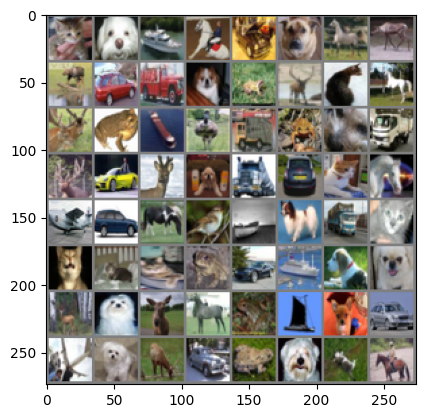

cat   dog   ship  horse automobile dog   horse deer  deer  automobile truck dog   frog  deer  cat   horse deer  frog  ship  bird  truck frog  dog   truck deer  automobile deer  dog   truck automobile cat   horse


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Lấy ngẫu nhiên ảnh trong train_loader
dataiter = iter(train_loader1)
images, labels = next(dataiter)

# Show ảnh
imshow(torchvision.utils.make_grid(images))
# In nhãn
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## XÂY DỰNG MÔ HÌNH

### MLP

MỘt LỚP ẨN

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class MLP1(nn.Module):
  def __init__(self):
    super(MLP1, self).__init__()
    input_size = 3 * 32 * 32
    hidden_size = 512
    num_classes = 10
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

HAI LỚP ẨN

In [41]:
class MLP2(nn.Module):
  def __init__(self):
    super(MLP2, self).__init__()
    input_size = 3 * 32 * 32
    hidden_size1 = 512
    hidden_size2 = 256
    num_classes = 10
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size1,hidden_size2)
    self.fc3 = nn.Linear(hidden_size2, num_classes)
    self.dropout = nn.Dropout(0.6)

  def forward(self, x):
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### CNN

In [67]:
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

## HÀM HUẤN LUYỆN VÀ ĐÁNH GIÁ

In [15]:
# Hàm huấn luyện
def train(model, train_loader, criterion, optimizer, device):
  model.to(device)
  model.train()
  running_loss = 0.0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device )
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  return running_loss/len(train_loader)

In [16]:
# Hàm đánh giá
def evaluate(model, test_loader, criterion, device):
  model.to(device)
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  average_loss = running_loss / len(test_loader)
  accuracy = 100 * correct / total

  return average_loss,accuracy

## HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### MLP1

In [ ]:
# Tạo mô hình MLP1
# Điều chỉnh với các siêu tham số khác nhau
'''
*   optimizer = Adam,SGD
*   batch size = 32,64
*   learning rate = 0.001,0.01
'''
model_MLP1 = MLP1().to(device)
batch_size = 64
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.SGD(model_MLP1.parameters(), lr=learning_rate)

In [ ]:
#Tạo file log MLP1
log_file = 'training_log1.txt'
with open(log_file, 'a') as f:
  f.write(f"training_log1.txt\n")

In [ ]:
#Thêm siêu tham số mô hình vào file log
log_file = 'training_log1.txt'
with open(log_file, 'a') as f:
  f.write(f"Optimizer: SGD, Batch Size: {batch_size}, Learning Rate: {learning_rate}\n")

In [ ]:
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 30
for epoch in range(num_epochs):
    # Huấn luyện
    train_loss = train(model_MLP1, train_loader1, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Đánh giá
    test_loss, accuracy = evaluate(model_MLP1, test_loader1, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    #Ghi vào file log
    with open(log_file, 'a') as f:
      f.write(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

    # Hiển thị kết quả
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/30, Train Loss: 1.8908, Test Loss: 1.7222, Accuracy: 40.42%
Epoch 2/30, Train Loss: 1.7024, Test Loss: 1.6171, Accuracy: 44.23%
Epoch 3/30, Train Loss: 1.6312, Test Loss: 1.5662, Accuracy: 45.82%
Epoch 4/30, Train Loss: 1.5817, Test Loss: 1.5269, Accuracy: 47.55%
Epoch 5/30, Train Loss: 1.5488, Test Loss: 1.5003, Accuracy: 48.24%
Epoch 6/30, Train Loss: 1.5180, Test Loss: 1.4739, Accuracy: 49.23%
Epoch 7/30, Train Loss: 1.4908, Test Loss: 1.4588, Accuracy: 49.11%
Epoch 8/30, Train Loss: 1.4702, Test Loss: 1.4345, Accuracy: 50.51%
Epoch 9/30, Train Loss: 1.4474, Test Loss: 1.4299, Accuracy: 50.56%
Epoch 10/30, Train Loss: 1.4287, Test Loss: 1.4071, Accuracy: 51.45%
Epoch 11/30, Train Loss: 1.4115, Test Loss: 1.3947, Accuracy: 51.74%
Epoch 12/30, Train Loss: 1.3933, Test Loss: 1.3921, Accuracy: 51.79%
Epoch 13/30, Train Loss: 1.3799, Test Loss: 1.3782, Accuracy: 52.26%
Epoch 14/30, Train Loss: 1.3647, Test Loss: 1.3667, Accuracy: 52.48%
Epoch 15/30, Train Loss: 1.3502, Test Loss:

In [ ]:
test_losses_MLP1 = []
test_accuracies_MLP1 = []

In [ ]:
#Thêm kết quả cuối cùng của các model với các siêu tham số khác nhau
test_losses_MLP1.append(test_losses[-1])
test_accuracies_MLP1.append(test_accuracies[-1])

In [ ]:
test_accuracies_MLP1 = [accuracy / 100 for accuracy in test_accuracies_MLP1]

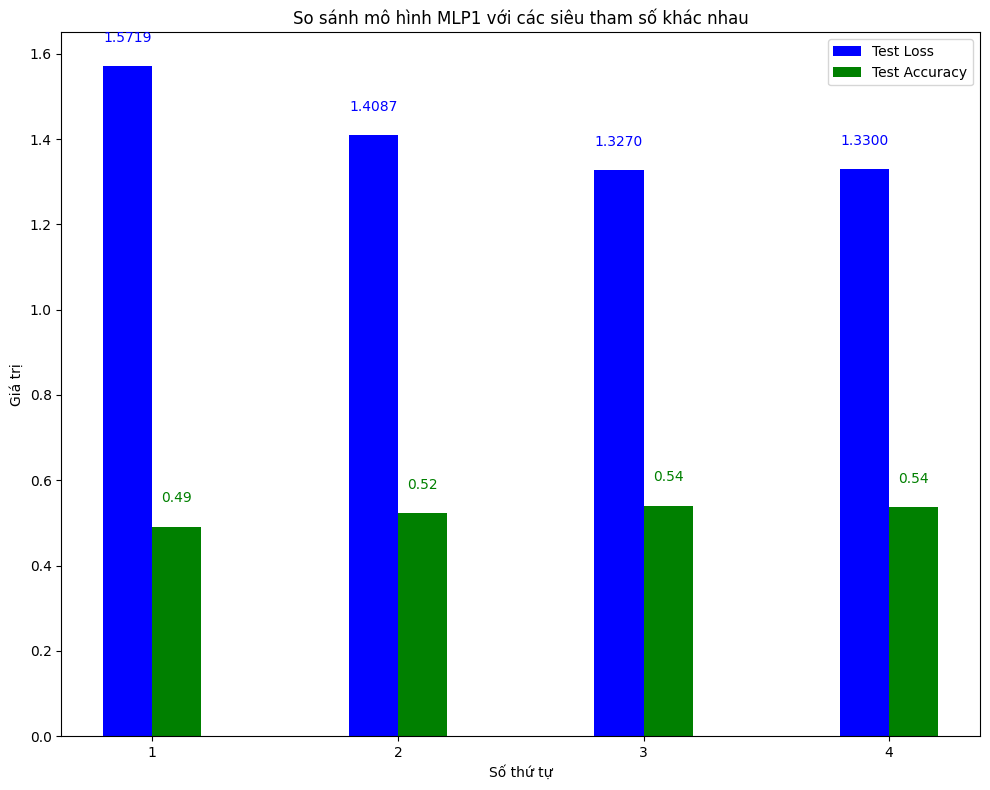

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Số epoch
epochs = np.arange(1, len(test_losses_MLP1) + 1)

# Tạo biểu đồ cột
fig, ax = plt.subplots(figsize=(10, 8))

# Đặt chiều rộng của các cột
width = 0.2  # Chiều rộng cột

# Vẽ test_loss và test_accuracy
bar1 = ax.bar(epochs - width / 2, test_losses_MLP1, width, label='Test Loss', color='blue')
bar2 = ax.bar(epochs + width / 2, test_accuracies_MLP1, width, label='Test Accuracy', color='green')

# Thêm nhãn, tiêu đề và chú thích
ax.set_xlabel('Số thứ tự')
ax.set_ylabel('Giá trị')
ax.set_title('So sánh mô hình MLP1 với các siêu tham số khác nhau')
ax.set_xticks(epochs)
ax.legend()

for rect in bar1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.05, f'{height:.4f}', ha='center', va='bottom', fontsize=10, color='blue')

for rect in bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='green')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


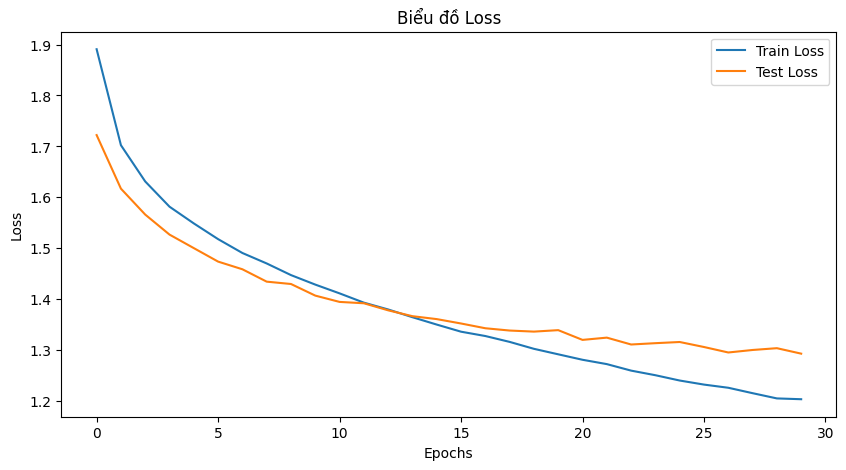

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Train Loss và Test Loss của mô hình MLP1 tốt nhất
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Biểu đồ Loss')
plt.legend()
plt.show()

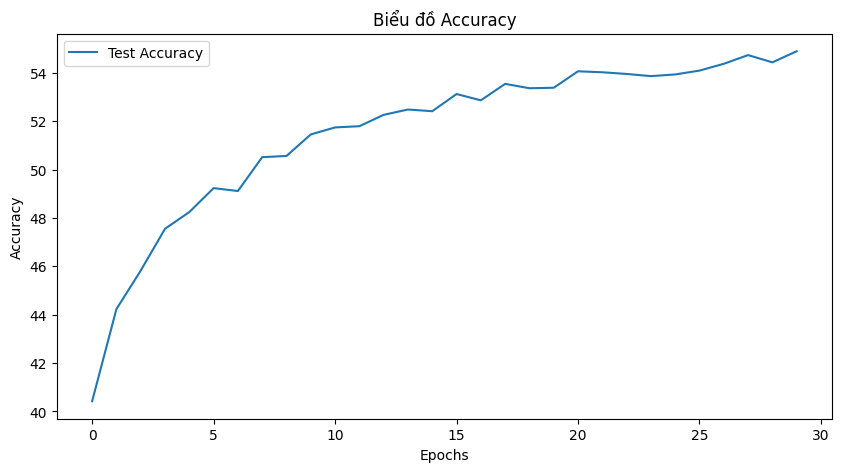

In [ ]:
# Vẽ biểu đồ Test Accuracy của mô hình MLP1 tốt nhất
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Biểu đồ Accuracy')
plt.legend()
plt.show()

In [ ]:
#Lưu mô hình MLP1
torch.save(model_MLP1.state_dict(), 'mlp1_cifar10.pth')

### MLP2

In [42]:
# Tạo mô hình MLP2
# Điều chỉnh với các siêu tham số khác nhau
'''
*   optimizer = Adam,SGD
*   batch size = 32,64
*   learning rate = 0.001,0.01
'''
model_MLP2 = MLP2().to(device)
batch_size = 32
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.SGD(model_MLP2.parameters(), lr=learning_rate, weight_decay=1e-4)

In [20]:
#Tạo file log MLP2
log_file = 'training_log2.txt'
with open(log_file, 'a') as f:
  f.write(f"training_log2.txt\n")

In [21]:
#Thêm siêu tham số mô hình vào file log
log_file = 'training_log2.txt'
with open(log_file, 'a') as f:
  f.write(f"Optimizer: SGD, Batch Size: {batch_size}, Learning Rate: {learning_rate}\n")

In [43]:
# Mảng lưu trữ loss và accuracy
train_losses = []
test_losses = []
test_accuracies = []

# Huấn luyện mô hình
num_epochs = 30
for epoch in range(num_epochs):
    # Huấn luyện
    train_loss = train(model_MLP2, train_loader2, criterion, optimizer, device)
    train_losses.append(train_loss)  # Lưu train loss

    # Đánh giá
    test_loss, accuracy = evaluate(model_MLP2, test_loader2, criterion, device)
    test_losses.append(test_loss)  # Lưu test loss
    test_accuracies.append(accuracy)  # Lưu test accuracy

    #Ghi vào file log
    with open(log_file, 'a') as f:
      f.write(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

    # Hiển thị kết quả
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/30, Train Loss: 1.9552, Test Loss: 1.7248, Accuracy: 39.17%
Epoch 2/30, Train Loss: 1.7145, Test Loss: 1.5974, Accuracy: 43.67%
Epoch 3/30, Train Loss: 1.6336, Test Loss: 1.5266, Accuracy: 46.52%
Epoch 4/30, Train Loss: 1.5777, Test Loss: 1.4862, Accuracy: 48.05%
Epoch 5/30, Train Loss: 1.5358, Test Loss: 1.4440, Accuracy: 49.19%
Epoch 6/30, Train Loss: 1.4982, Test Loss: 1.4159, Accuracy: 50.85%
Epoch 7/30, Train Loss: 1.4715, Test Loss: 1.4152, Accuracy: 49.77%
Epoch 8/30, Train Loss: 1.4446, Test Loss: 1.3802, Accuracy: 51.80%
Epoch 9/30, Train Loss: 1.4219, Test Loss: 1.3658, Accuracy: 52.11%
Epoch 10/30, Train Loss: 1.4015, Test Loss: 1.3503, Accuracy: 52.23%
Epoch 11/30, Train Loss: 1.3843, Test Loss: 1.3401, Accuracy: 52.50%
Epoch 12/30, Train Loss: 1.3674, Test Loss: 1.3337, Accuracy: 53.27%
Epoch 13/30, Train Loss: 1.3497, Test Loss: 1.3251, Accuracy: 53.92%
Epoch 14/30, Train Loss: 1.3362, Test Loss: 1.3128, Accuracy: 53.44%
Epoch 15/30, Train Loss: 1.3198, Test Loss:

In [ ]:
test_losses_MLP2 = []
test_accuracies_MLP2 = []

In [ ]:
#Kết quả cuối cùng của các model với các siêu tham số khác nhau
test_losses_MLP2.append(test_losses[-1])
test_accuracies_MLP2.append(test_accuracies[-1])

In [ ]:
test_accuracies_MLP2 = [accuracy / 100 for accuracy in test_accuracies_MLP2]

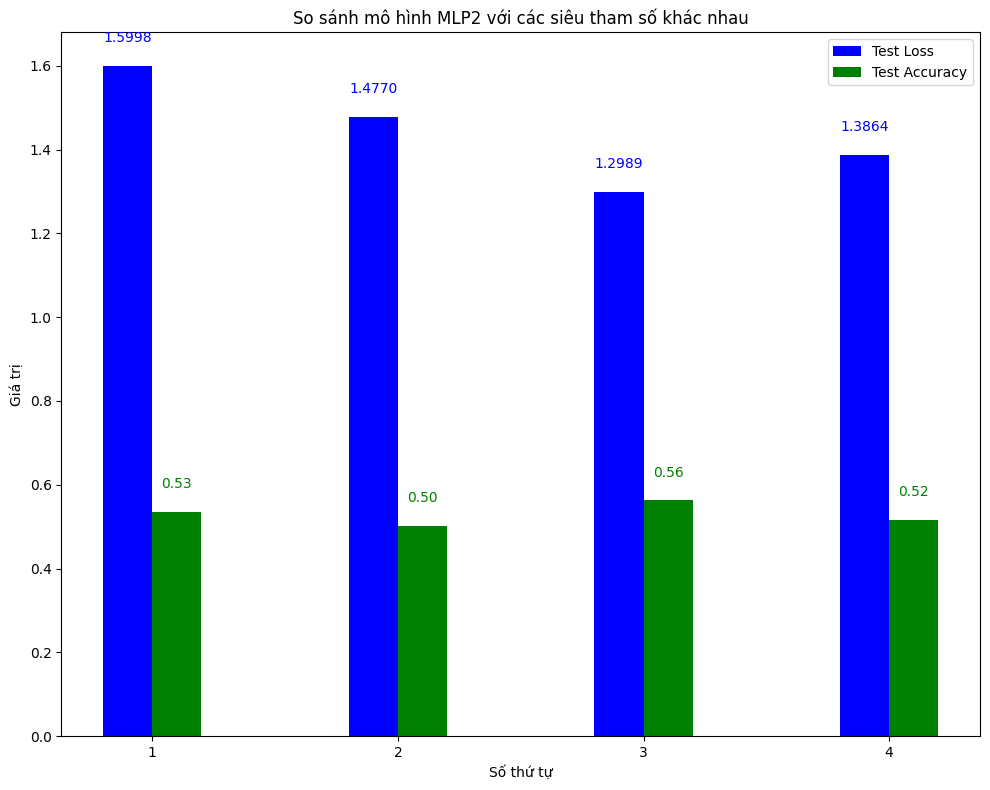

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Số epoch
epochs = np.arange(1, len(test_losses_MLP2) + 1)

# Tạo biểu đồ cột
fig, ax = plt.subplots(figsize=(10, 8))

# Đặt chiều rộng của các cột
width = 0.2  # Chiều rộng cột

# Vẽ test_loss và test_accuracy
bar1 = ax.bar(epochs - width / 2, test_losses_MLP2, width, label='Test Loss', color='blue')
bar2 = ax.bar(epochs + width / 2, test_accuracies_MLP2, width, label='Test Accuracy', color='green')

# Thêm nhãn, tiêu đề và chú thích
ax.set_xlabel('Số thứ tự')
ax.set_ylabel('Giá trị')
ax.set_title('So sánh mô hình MLP2 với các siêu tham số khác nhau')
ax.set_xticks(epochs)
ax.legend()

for rect in bar1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.05, f'{height:.4f}', ha='center', va='bottom', fontsize=10, color='blue')

for rect in bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='green')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

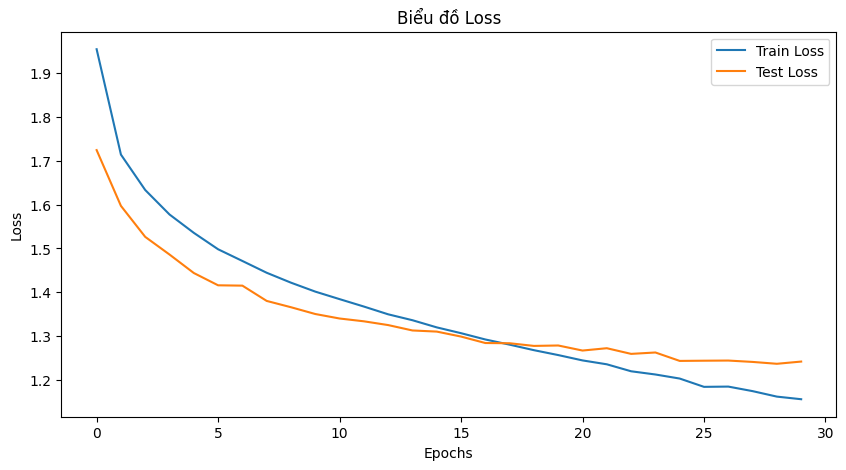

In [44]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Train Loss và Test Loss của mô hình MLP2 tốt nhất
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Biểu đồ Loss')
plt.legend()
plt.show()

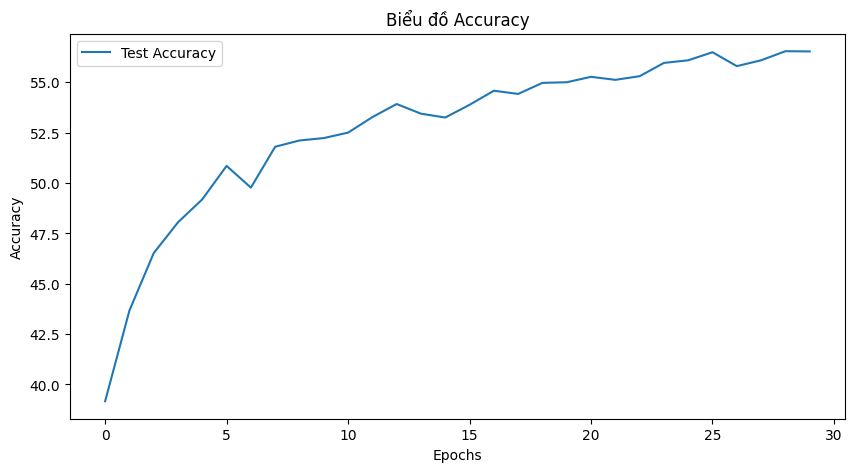

In [45]:
# Vẽ biểu đồ Test Accuracy của mô hình MLP2 tốt nhất
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Biểu đồ Accuracy')
plt.legend()
plt.show()

In [47]:
#Lưu mô hình MLP2
torch.save(model_MLP2.state_dict(), 'mlp2_cifar10.pth')

### CNN

In [69]:
# Tạo mô hình CNN
# Điều chỉnh với các siêu tham số khác nhau
'''
*   optimizer = Adam,SGD
*   batch size = 32,64
*   learning rate = 0.001,0.01
'''
model_CNN = CNN().to(device)
batch_size = 32
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model_CNN.parameters(), lr=learning_rate,weight_decay=1e-4)

In [49]:
#Tạo file log CNN
log_file = 'training_logCNN.txt'
with open(log_file, 'a') as f:
  f.write(f"training_logCNN.txt\n")

In [72]:
#Thêm siêu tham số mô hình vào file log
log_file = 'training_logCNN.txt'
with open(log_file, 'a') as f:
  f.write(f"Optimizer: Adam, Batch Size: {batch_size}, Learning Rate: {learning_rate}\n")

In [70]:
#Số lượng epoch
#10-20:Điều chỉnh siêu tham số
#30:Mô hình tốt nhất
num_epochs = 30

In [73]:
# Mảng lưu trữ loss và accuracy
train_losses = []
test_losses = []
test_accuracies = []

# Huấn luyện mô hình
for epoch in range(num_epochs):
    # Huấn luyện
    train_loss = train(model_CNN, train_loader2, criterion, optimizer, device)
    train_losses.append(train_loss)  # Lưu train loss

    # Đánh giá
    test_loss, accuracy = evaluate(model_CNN, test_loader2, criterion, device)
    test_losses.append(test_loss)  # Lưu test loss
    test_accuracies.append(accuracy)  # Lưu test accuracy

    #Ghi vào file log
    with open(log_file, 'a') as f:
      f.write(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

    # Hiển thị kết quả
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/30, Train Loss: 1.5981, Test Loss: 1.4044, Accuracy: 49.06%
Epoch 2/30, Train Loss: 1.3822, Test Loss: 1.2523, Accuracy: 55.19%
Epoch 3/30, Train Loss: 1.2657, Test Loss: 1.2025, Accuracy: 57.40%
Epoch 4/30, Train Loss: 1.1917, Test Loss: 1.1783, Accuracy: 57.65%
Epoch 5/30, Train Loss: 1.1290, Test Loss: 1.1823, Accuracy: 58.03%
Epoch 6/30, Train Loss: 1.0772, Test Loss: 1.1020, Accuracy: 60.98%
Epoch 7/30, Train Loss: 1.0354, Test Loss: 1.0919, Accuracy: 61.93%
Epoch 8/30, Train Loss: 0.9981, Test Loss: 1.0589, Accuracy: 62.97%
Epoch 9/30, Train Loss: 0.9662, Test Loss: 1.0795, Accuracy: 62.74%
Epoch 10/30, Train Loss: 0.9360, Test Loss: 1.0740, Accuracy: 63.37%
Epoch 11/30, Train Loss: 0.9140, Test Loss: 1.0762, Accuracy: 63.51%
Epoch 12/30, Train Loss: 0.8952, Test Loss: 1.0419, Accuracy: 64.33%
Epoch 13/30, Train Loss: 0.8713, Test Loss: 1.0976, Accuracy: 63.45%
Epoch 14/30, Train Loss: 0.8473, Test Loss: 1.0739, Accuracy: 63.75%
Epoch 15/30, Train Loss: 0.8340, Test Loss:

In [ ]:
test_losses_CNN = []
test_accuracies_CNN = []

In [ ]:
#Kết quả cuối cùng của các model với các siêu tham số khác nhau
test_losses_CNN.append(test_losses[-1])
test_accuracies_CNN.append(test_accuracies[-1])

In [ ]:
test_accuracies_CNN = [accuracy / 100 for accuracy in test_accuracies_CNN]

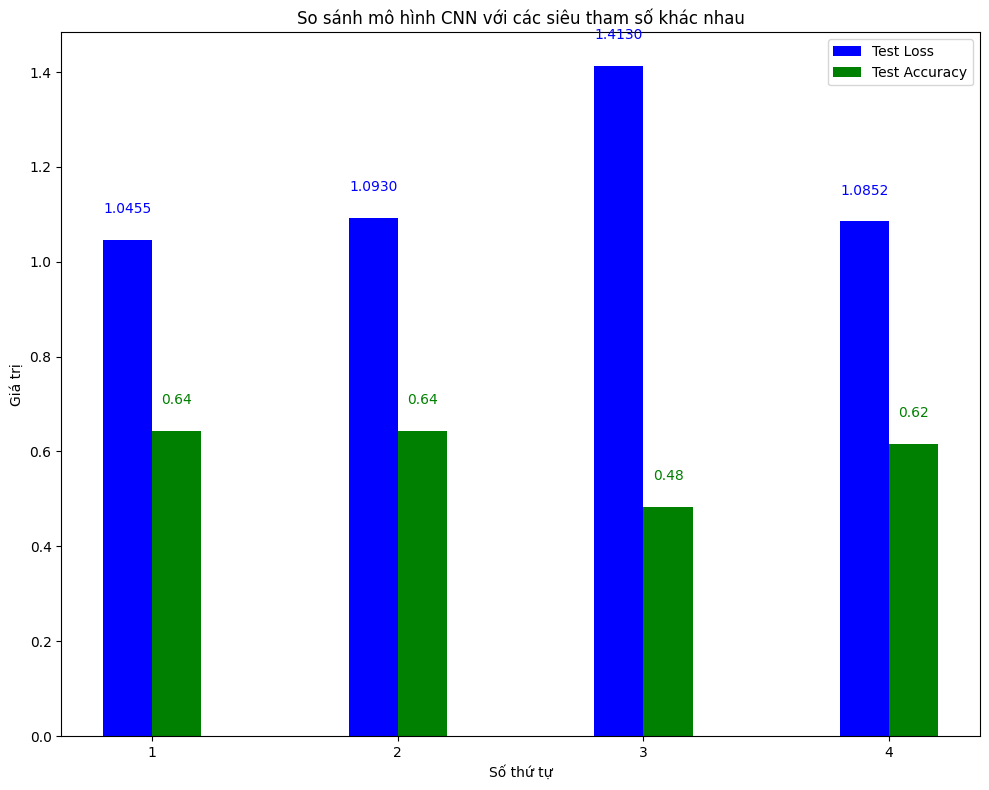

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Số epoch
epochs = np.arange(1, len(test_losses_CNN) + 1)

# Tạo biểu đồ cột
fig, ax = plt.subplots(figsize=(10, 8))

# Đặt chiều rộng của các cột
width = 0.2

# Vẽ test_loss và test_accuracy
bar1 = ax.bar(epochs - width / 2, test_losses_CNN, width, label='Test Loss', color='blue')
bar2 = ax.bar(epochs + width / 2, test_accuracies_CNN, width, label='Test Accuracy', color='green')

# Thêm nhãn, tiêu đề và chú thích
ax.set_xlabel('Số thứ tự')
ax.set_ylabel('Giá trị')
ax.set_title('So sánh mô hình CNN với các siêu tham số khác nhau')
ax.set_xticks(epochs)
ax.legend()

for rect in bar1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.05, f'{height:.4f}', ha='center', va='bottom', fontsize=10, color='blue')

for rect in bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='green')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


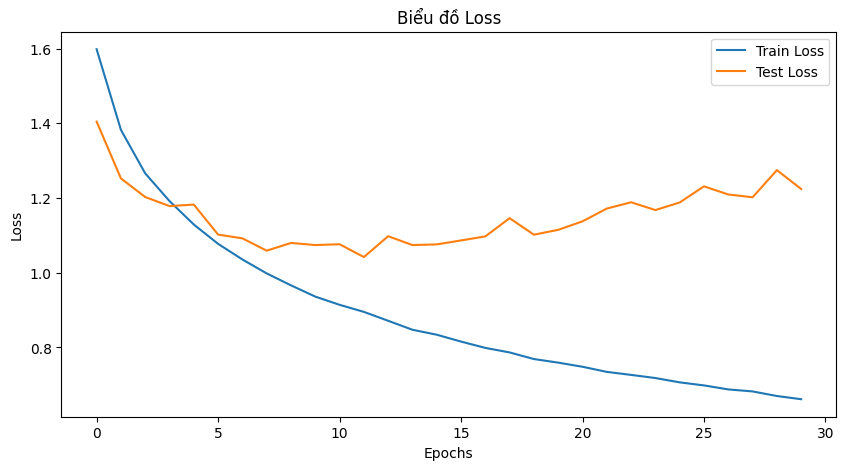

In [74]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Train Loss và Test Loss của mô hình CNN tốt nhất
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Biểu đồ Loss')
plt.legend()
plt.show()

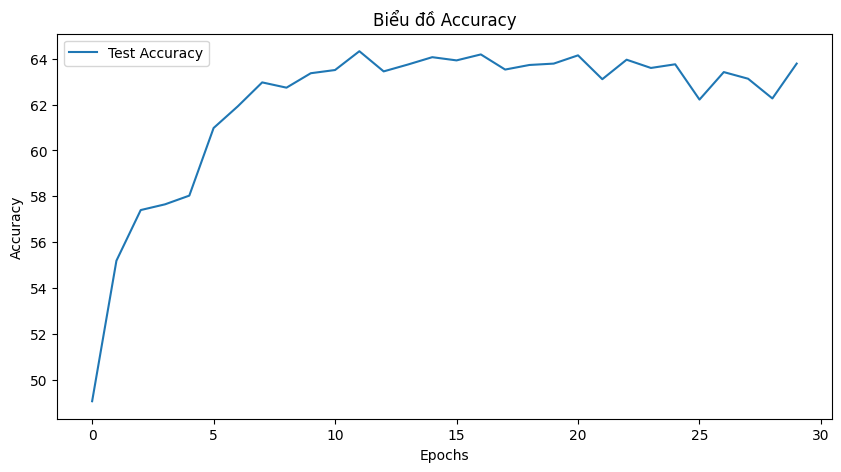

In [75]:
# Vẽ biểu đồ Test Accuracy của mô hình CNN tốt nhất
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Biểu đồ Accuracy')
plt.legend()
plt.show()

In [78]:
#Lưu mô hình CNN
torch.save(model_CNN.state_dict(), 'CNN_cifar10.pth')

## PHÂN TÍCH KẾT QUẢ

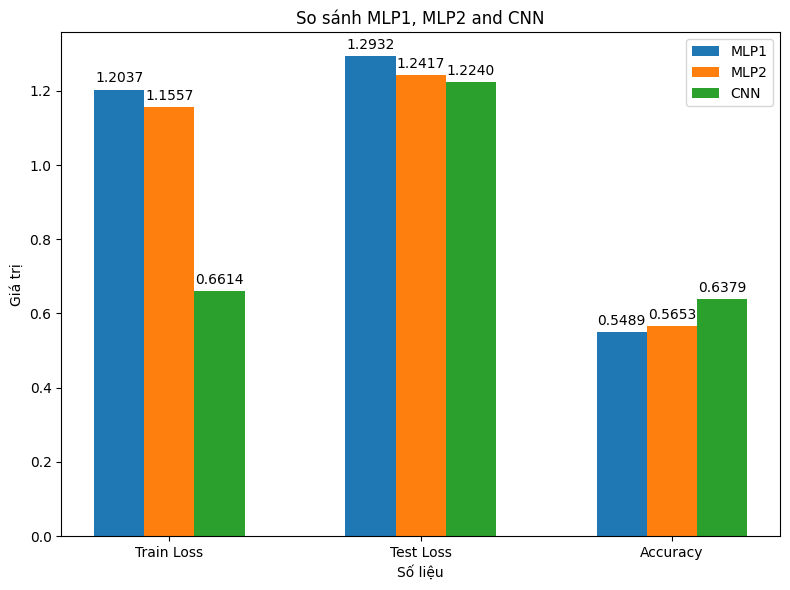

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu của mô hình tốt nhất
MLP1 = [1.2037, 1.2932, 0.5489]
MLP2 = [1.1557, 1.2417, 0.5653]
CNN = [0.6614, 1.2240, 0.6379]

# Các label cho trục x
labels = ['Train Loss', 'Test Loss', 'Accuracy']

# Số lượng nhóm cột
x = np.arange(len(labels))

# Chiều rộng của các cột
width = 0.2

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width, MLP1, width, label='MLP1')
rects2 = ax.bar(x, MLP2, width, label='MLP2')
rects3 = ax.bar(x + width, CNN, width, label='CNN')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Số liệu')
ax.set_ylabel('Giá trị')
ax.set_title('So sánh MLP1, MLP2 and CNN')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hiển thị giá trị trong các cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Gọi hàm để hiển thị giá trị
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
